In [1]:
import numpy as np
import json
import torch
import os
import random
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from cbam import CBAM
import utils_inference
import napari
from scipy import ndimage
import synthetic_data_generator.seismogram_generator as seismogram_generator

/home/alexsey/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('config.json', 'r') as f:
    config = json.load(f)

In [3]:
model = smp.MAnet(
    encoder_name="resnet34",       
    encoder_weights=None,     
    in_channels=1,                  
    classes=2,
    activation='softmax',
    decoder_pab_channels = 64
)
loss_function = torch.nn.BCEWithLogitsLoss()

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_folder_path, mask_folder_path):
        'Initialization'
        pass

    def __len__(self):
        'Denotes the total number of samples'
        return 5000

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        # Load data and get label
        X,y = seismogram_generator.get_sample()
        print(X.shape, y.shape)
        return X[None,:,:].float(), y.float()

In [5]:
def dice_loss(pred, target, smooth=1.):
    """Dice loss
    """
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

In [6]:
directory_data = config["directory_data_path"]
directory_mask = config["directory_mask_path"]

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model.to(device)

MAnet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

model.load_state_dict(torch.load('test_softmax_30000_28epoch'))

In [8]:
params = {'batch_size': config['batch_size'],
          'shuffle': config['shuffle']}

In [9]:
training_set = Dataset(directory_data, directory_mask)
training_generator = torch.utils.data.DataLoader(training_set, **params)

torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])


/home/alexsey/miniconda3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


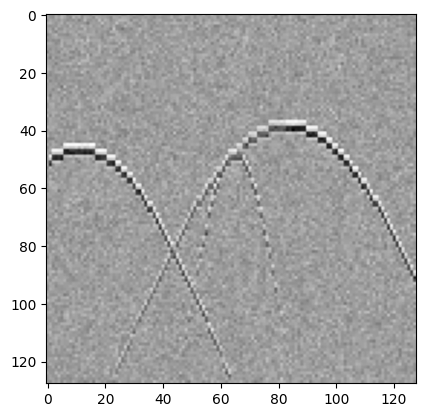

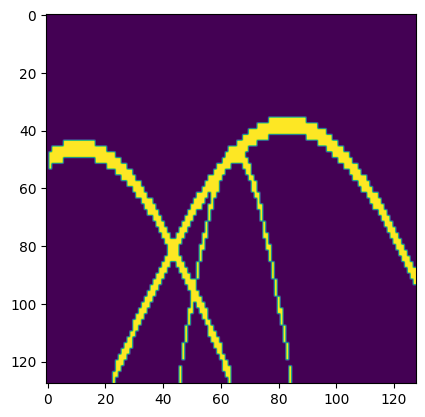

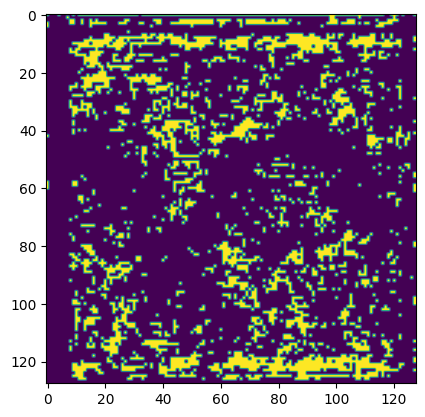

torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])
torch.Size([128, 128]) torch.Size([2, 128, 128])


KeyboardInterrupt: 

In [10]:
lr_pow = config['learning_rate_pow']
epochs = config['max_epochs']
epoch_losses = []
mean_losses = []
output_num = 0
for epoch in range(epochs):
    losses = []
    
    optimizer =  torch.optim.Adam(model.parameters(),
                              lr = 10**lr_pow)
    for num, trace in enumerate(training_generator):
        trace_ = trace[0].to(device)
        optimizer.zero_grad()
        reconstructed = model(trace_)
        trace_y = trace[1].to(device)
        loss = dice_loss(reconstructed, trace_y) + loss_function(reconstructed, trace_y)
        losses.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
        if num % 100 == 0:
            # result = torch.argmax(model(trace_).cpu().detach(),dim = 1)
            # for i in range(result.shape[0]):
            #     torch.save(result[i], f"data_for_fix_mask/predict/{output_num}.pt")
            #     torch.save(trace_y[i,0,:,:], f"data_for_fix_mask/mask/{output_num}.pt")
            #     output_num += 1
                
        
            plt.imshow(trace_.cpu()[0,0,:,:],cmap = 'Greys')
            plt.show()
            plt.imshow(trace_y.cpu()[0,0,:,:])
            plt.show()
            plt.imshow(torch.argmax(model(trace_)[0].cpu().detach(),dim = 0)[:,:])
            plt.show()
        del trace
        del trace_
        del trace_y
    # if lr_pow == -6:
    #     lr_pow = -5
    # else:
    #     lr_pow -= 1
    mean_losses.append(np.mean(losses))
    plt.plot(mean_losses)
    plt.show()

In [ ]:
model.cpu()

torch.save(model.cpu().state_dict(), 'test_softmax_3000_15epoch_new_impulse')

In [ ]:
path = config["test_sample_path"]
format_ = (128, 128)
data_test_full = utils_inference.load_segy_file(path, format_)[:128*4]

In [ ]:
after_model = utils_inference.get_transform_sgy(data_test_full,model, format_)

In [ ]:
after_model = 1 - after_model.astype(int)

In [ ]:
viewer = napari.view_image(data_test_full)
labels_layer = viewer.add_labels(after_model, name='segmentation')
napari.run()

In [ ]:
viewer = napari.view_image(after_model)
napari.run()

In [ ]:
viewer = napari.view_image(after_model * data_test_full)
napari.run()